# Finetune A Pretrained GPT-2 Model On IMDB

- [x] M1
- [x] Colab
- [ ] [Wakaka/bert-finetuned-imdb](https://huggingface.co/Wakaka/bert-finetuned-imdb)
- [ ] [Damon-Salvatore-liu/bert_imdb](https://github.com/Damon-Salvatore-liu/bert_imdb/blob/main/test.ipynb)

In [1]:
DATASET="imdb"

MODEL="gpt2"

In [2]:
import sys

print("Python:               ", sys.version)

Python:                3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]


In [3]:
import transformers, datasets, evaluate

print("Transformers Version:", transformers.__version__)
print("Datasets Version:    ", datasets.__version__)
print("Evaluate Version:    ", evaluate.__version__)

Transformers Version: 4.27.1
Datasets Version:     2.10.1
Evaluate Version:     0.2.2


In [4]:
!rm -rf checkpoints/*

!rm -rf model/*

zsh:1: no matches found: checkpoints/*
zsh:1: no matches found: model/*


## Get Raw IMDB Dataset of 50K Movie Reviews

In [5]:
from datasets import load_dataset_builder

imdbreviews_dataset_builder = load_dataset_builder(DATASET)

In [6]:
print(imdbreviews_dataset_builder.info.description)

Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.


In [7]:
from datasets import load_dataset

imdbreviews_datasets = load_dataset(DATASET)

Found cached dataset imdb (/Users/lothar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
imdbreviews_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## Get Pretrained GPT-2 Tokenizer And Model

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

## Prepare Data

In [11]:
def tokenize(examples):
    outputs = tokenizer(examples['text'], padding=True, truncation=True, max_length=512)
    return outputs

tokenized_imdbreviews_datasets = imdbreviews_datasets.map(tokenize, batched=True)

Loading cached processed dataset at /Users/lothar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-f84331f291d42698.arrow
Loading cached processed dataset at /Users/lothar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-82f0693f6bc6972a.arrow
Loading cached processed dataset at /Users/lothar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-eada2e42c71f05b3.arrow


In [12]:
tokenized_imdbreviews_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [13]:
small_train_dataset = tokenized_imdbreviews_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_imdbreviews_datasets["test"].shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /Users/lothar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9b55e236c2a8f21f.arrow
Loading cached shuffled indices for dataset at /Users/lothar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-2ffc9ec39cdfe68b.arrow


In [14]:
full_train_dataset = tokenized_imdbreviews_datasets["train"]
full_eval_dataset = tokenized_imdbreviews_datasets["test"]

In [15]:
train_dataset = small_train_dataset

eval_dataset = small_eval_dataset

## Finetune Pretrained GPT-2 Model

### Metrics

In [16]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy", "loss")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

### Training Arguments

In [17]:
from transformers import TrainingArguments

SEED=42
BATCH_SIZE=8

args = TrainingArguments(
    seed=SEED,
    output_dir="./checkpoints",             # checkpointing
    overwrite_output_dir=True,
    save_strategy="epoch",                  # evaluating+saving
    evaluation_strategy="epoch",
    logging_dir="logs",                     # logging
    logging_strategy="no",
    per_device_train_batch_size=BATCH_SIZE, # batching
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,
    learning_rate=5e-05,
    lr_scheduler_type="linear",
    weight_decay=0,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-08,
    optim="adamw_torch",
    use_mps_device=True                     # accelerating
)

### Trainer

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

## Training

In [19]:
trainer.train()

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.33757448196411133, 'eval_accuracy': 0.886, 'eval_runtime': 33.785, 'eval_samples_per_second': 29.599, 'eval_steps_per_second': 3.7, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.38446563482284546, 'eval_accuracy': 0.88, 'eval_runtime': 33.2571, 'eval_samples_per_second': 30.069, 'eval_steps_per_second': 3.759, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.4848141372203827, 'eval_accuracy': 0.888, 'eval_runtime': 33.315, 'eval_samples_per_second': 30.016, 'eval_steps_per_second': 3.752, 'epoch': 3.0}
{'train_runtime': 434.238, 'train_samples_per_second': 6.909, 'train_steps_per_second': 0.864, 'train_loss': 0.32628098551432294, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.32628098551432294, metrics={'train_runtime': 434.238, 'train_samples_per_second': 6.909, 'train_steps_per_second': 0.864, 'train_loss': 0.32628098551432294, 'epoch': 3.0})

## Save Finetuned Model Locally

In [20]:
trainer.model.save_pretrained(save_directory="model")

In [21]:
MODEL_NAME="wip-gpt2-finetuned-imdbreviews-fast"

model.push_to_hub(MODEL_NAME)

tokenizer.push_to_hub(MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/lwieske/wip-gpt2-finetuned-imdbreviews-fast/commit/5e9d834c3440dda9acd2f5bcdfca059f5b7c5584', commit_message='Upload tokenizer', commit_description='', oid='5e9d834c3440dda9acd2f5bcdfca059f5b7c5584', pr_url=None, pr_revision=None, pr_num=None)

In [22]:
step_list = [log['step'] for log in trainer.state.log_history[:-1]]

eval_loss_list = [log['eval_loss'] for log in trainer.state.log_history[:-1]]

eval_accuracy_list = [log['eval_accuracy'] for log in trainer.state.log_history[:-1]]

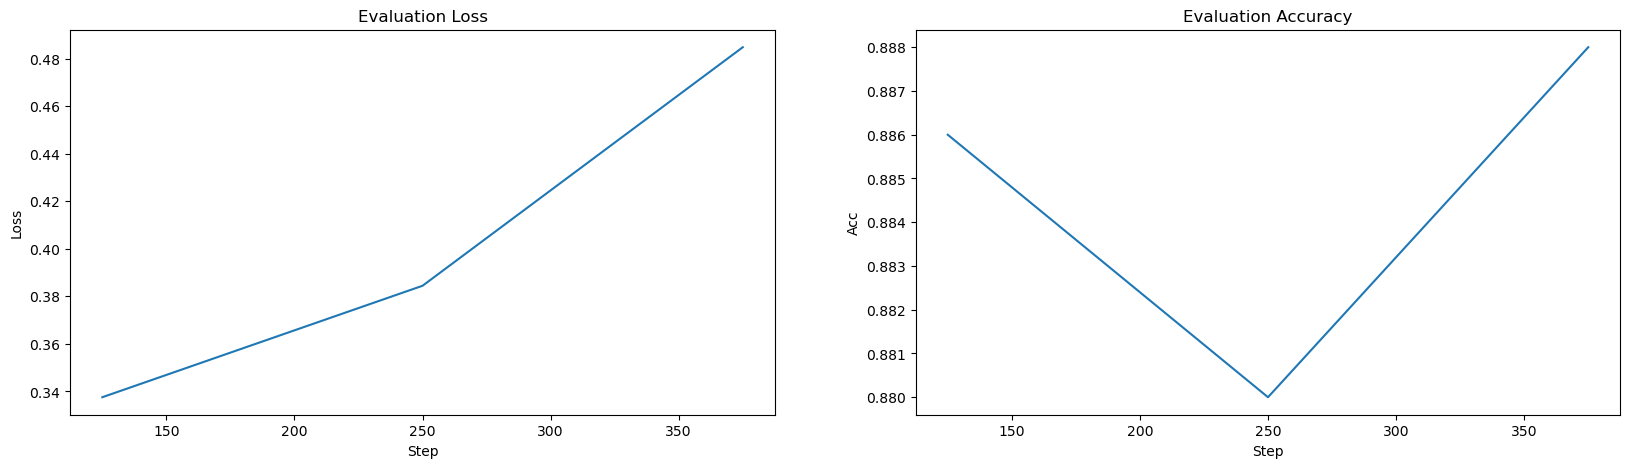

In [23]:
import matplotlib.pyplot as plt

plt.subplots(1,2, figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("Evaluation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(step_list, eval_loss_list)

plt.subplot(1, 2, 2)
plt.title("Evaluation Accuracy")
plt.xlabel("Step")
plt.ylabel("Acc")
plt.plot(step_list, eval_accuracy_list)

plt.show()

In [24]:
!tree checkpoints

checkpoints
├── checkpoint-125
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── trainer_state.json
│   └── training_args.bin
├── checkpoint-250
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── trainer_state.json
│   └── training_args.bin
└── checkpoint-375
    ├── config.json
    ├── optimizer.pt
    ├── pytorch_model.bin
    ├── rng_state.pth
    ├── scheduler.pt
    ├── trainer_state.json
    └── training_args.bin

4 directories, 21 files


In [25]:
!tree model

model
├── config.json
└── pytorch_model.bin

1 directory, 2 files
